In [1]:
!pip install --upgrade pip
!pip install textgenrnn
!pip3 install --upgrade tensorflow keras
# !conda update
# !conda install tensorflow keras
# nvcc --version
!pip3 install --upgrade scipy
!pip install --upgrade six
!pip install --upgrade grpcio

Requirement already up-to-date: pip in /Users/birdshaw/anaconda3/lib/python3.7/site-packages (20.0.2)
Requirement already up-to-date: tensorflow in /Users/birdshaw/anaconda3/lib/python3.7/site-packages (2.1.0)
Requirement already up-to-date: keras in /Users/birdshaw/anaconda3/lib/python3.7/site-packages (2.3.1)


Requirement already up-to-date: scipy in /Users/birdshaw/anaconda3/lib/python3.7/site-packages (1.4.1)
ERROR: astroid 2.3.1 requires typed-ast<1.5,>=1.4.0; implementation_name == "cpython" and python_version < "3.8", which is not installed.
ERROR: astroid 2.3.1 has requirement six==1.12, but you'll have six 1.14.0 which is incompatible.
  Attempting uninstall: six
    Found existing installation: six 1.12.0
    Uninstalling six-1.12.0:
      Successfully uninstalled six-1.12.0
     |████████████████████████████████| 2.5 MB 2.2 MB/s eta 0:00:01
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.27.1
    Uninstalling grpcio-1.27.1:
      Successfully uninstalled grpcio-1.27.1


In [48]:
import pandas as pd
import numpy as np
import unicodedata
import string
import re
import matplotlib.pyplot as plt
import seaborn as sns

from textgenrnn import textgenrnn

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Embedding, Dense, LSTM, Bidirectional

In [49]:
# Read in csv file

df = pd.read_csv('no_data/drinksandcocktails_1.0.9.csv', escapechar='\\')

In [50]:
# Filter out only the category desired

df_drink = df[(df['d_cat'] == 'Ordinary Drink') | (df['d_cat'] == 'Cocktail')]

In [51]:
# Drop null rows

df_drink = df_drink.dropna(axis='index')

In [64]:
# Reformate data in d_ingredients column and place in new column

df_drink['ingredients'] = (df_drink['d_ingredients'].str.split('|').str.join(', ').tolist())

In [62]:
# Turn d_shopping into a list

df_drink['d_shopping'] = df_drink['d_shopping'].str.split('|')

In [53]:
df_drink['d_shopping'].head().values

array([list(['Vodka', 'Southern Comfort', 'Grand Marnier', 'Pineapple juice']),
       list(['Jack Daniels', 'Vodka', 'Dr. Pepper', 'Sugar', 'Cherry']),
       list(['Creme de Cacao', 'Vodka']),
       list(['Dark rum', 'Light rum', 'Vodka', 'Orange juice']),
       list(['Gin', 'Light rum', 'Tequila', 'Triple sec', 'Vodka', 'Coca-Cola', 'Sweet and sour', 'Bitters', 'Lemon'])],
      dtype=object)

## EDA

In [390]:
ing = 0

for idx, row in df_drink.iterrows():
    ing += len(df_drink.loc[idx, 'd_shopping'])
    
        

In [54]:
df_uniq = df_drink.copy()
df_uniq.d_ingredients = df_uniq.d_ingredients.str.split('|')
df_uniq['d_ingredients'].unique

<bound method Series.unique of 1        [1/2 oz Vodka, 1 1/2 oz Southern Comfort, 1/2 ...
4        [1 shot Jack Daniels, 1 shot Vodka, 6 shots Dr...
6                  [1 oz white Creme de Cacao, 1 oz Vodka]
10       [1 shot Dark rum, 2 shots Light rum, 1 shot Vo...
12       [1/2 oz Gin, 1/2 oz Light rum, 1/2 oz Tequila,...
                               ...                        
16346    [1/2 oz light rum, 3/4 oz gold rum, 1/4 oz apr...
16347    [1 oz creme de cassis, 1 oz vodka, 1/2 oz peac...
16348    [1 oz creme de cacao, 1 oz amaretto almond liq...
16349    [2 oz tequila, 1/2 oz Galliano(R) herbal lique...
16350    [1 oz dark rum, 1 oz dark creme de cacao, 1/2 ...
Name: d_ingredients, Length: 12294, dtype: object>

In [56]:
# Finding max and minimum length of ingredients used in cocktails

print(df_uniq['d_shopping'].map(len).min())
print(df_uniq['d_shopping'].map(len).max())

1
16


In [392]:
df_drink.shape

(12294, 9)

In [405]:
print('Average number of ingredients in a cocktail: {:.1f}'.format(ing / df_drink.shape[0]))

Average number of ingredients in a cocktail: 4.0


In [58]:
# Used to get total number of ingredients used

d = {}

for idx, row in df_drink.iterrows():
    lst = df_drink.loc[idx, 'd_shopping']
#     lst = lst.lower()
    for j in range(len(row['d_shopping'])):
        if lst[j].lower() not in d:
            d[lst[j].lower()] = 1
        else:
            d[lst[j].lower()] += 1

In [336]:
# Turn dictionary to dataframe, sort, then plot

df_items = pd.DataFrame.from_dict(data = d, orient = 'index')

df_items = df_items.sort_values(by = 0, ascending=False)

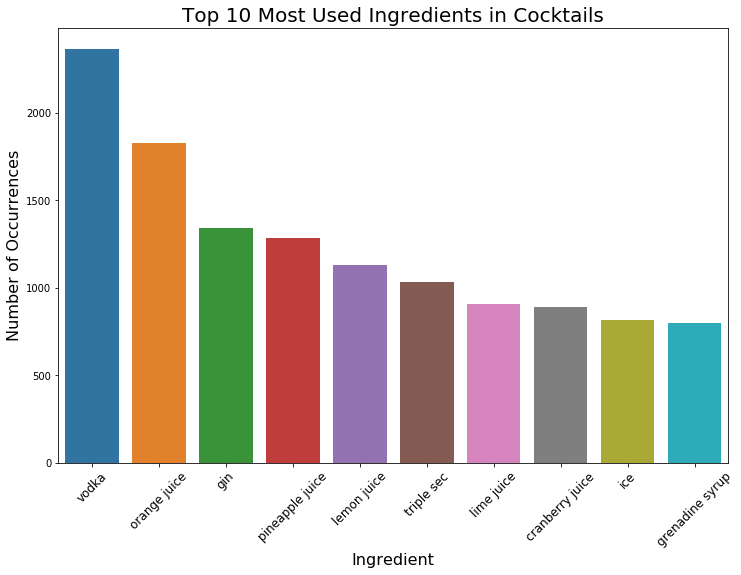

In [585]:

plt.figure(figsize=(12, 8))
sns.barplot(df_items.head(10).index, df_items[0].head(10))
plt.title('Top 10 Most Used Ingredients in Cocktails', fontsize = 20)
plt.ylabel('Number of Occurrences', fontsize=16)
plt.xlabel('Ingredient', fontsize=16)
plt.xticks(rotation=45, fontsize= 12)

plt.savefig('ingredient.png')

In [356]:
# Sort and check values of total uses of ingredients

df_items = df_items.sort_values(by = 0, ascending=False)


In [569]:
df_items

,0
vodka,2366
orange juice,1825
gin,1339
pineapple juice,1285
lemon juice,1130
...,...
tamarind,1
chile piqions,1
peruvian pisco brandy,1
elderflower cordial,1


In [582]:
# Create a copy of unregularized drinks for separate testing in RNN

df_unreg = df.copy()

df_unreg = df_unreg.dropna(axis='index')
df_unreg = df_unreg[(df_unreg['d_cat'] == 'Ordinary Drink') | (df_unreg['d_cat'] == 'Cocktail')]
df_unreg['ingredients'] = (df_unreg['d_ingredients'].str.split('|').str.join(', ').tolist())

df_unreg = df_unreg.sample(4000)

df_unreg = df_unreg.loc[:, ['d_name', 'ingredients']]

df_unreg.to_csv('unreg_drinks.txt',encoding='utf-8', header=None, index=False)

# Regularize the Data and turn to text

In [65]:
# Set up replacement of unique units of measure as well as fractions into decimals. Run twice so that values
# such as 1/2 that turns into 0.5 will also register with 1\s0.5 changing to 1.5

df_drink['ingredients'] = df_drink['ingredients'].replace(regex = {'1/2': '0.5','1/4': '0.25', '3/10': '0.3','2/10': '0.2','1/10': '0.1','1/8': '0.125',
                                     '1/3': '0.3','2/3': '0.6','3/4': '0.75','1\s0.5': '1.5','1\s0.25': '1.25',
                                     '1\s0.75': '1.75', '2\s0.25': '2.25', '2\s0.3':'2.3',  '2\s0.5': '2.5', '2\s0.75': '2.75','1-0.5': '1.5', '2 .6': '2.6','3/4': '0.75',
                                     '0.5-1|0.5 - 1': '0.75','1-2': '1.5','1 or 2': '1.5','1.5 - 2': '1.75', '1-2|1 - 2': '1.5',
                                     '1-1.5|1 - 1.5': '1.25','4-6': '5','6-7|6 - 7': '6.5','2-3|2 - 3': '2.5',
                                     '2.5-3|2.5 - 3': '2.75','3-4|3 - 4': '3.5','4-5|4 - 5': '4.5','5-7|5 - 7': '6',
                                     '2-4|2 - 4': '3','8-12|8 - 12': '10','7-8|7 - 8': '7.5','1-3|1 - 3': '2',
                                     '6-8|6 - 8': '7','8-10|8 - 10':'9','10-12|10 - 12': '11','6-10|6 - 10': '8',
                                     '1.5-2|1.5 - 2': '1.75','3-6|3 - 6': '4.5','3-5|3 - 5': '4','5-6|5 - 6': '5.5',
                                     '9-10|9 - 10': '9.5','5-10|5 - 10': '7.5','12-14|12 - 14': '13',
                                     '.75-3/2|.75 - 3/2': '1.125','30-45': '40','cups': 'cup','pints': 'pint',
                                     'quarts': 'quart','gallons': 'gallon', 'tblsp': 'tbsp'})

In [66]:
df_drink.head(10)

,id,d_name,d_cat,d_alcohol,d_glass,d_ingredients,d_instructions,d_shopping,ingredients
1,2,'57 Chevy,Cocktail,Alcoholic,Cocktail glass,1/2 oz Vodka|1 1/2 oz Southern Comfort|1/2 oz ...,Shake and serve.,NaN,"0.5 oz Vodka, 1 0.5 oz Southern Comfort, 0.5 o..."
4,5,187 URge,Cocktail,Alcoholic,Any Glass,1 shot Jack Daniels|1 shot Vodka|6 shots Dr. P...,Mix together and stir it is good,NaN,"1 shot Jack Daniels, 1 shot Vodka, 6 shots Dr...."
6,7,'57 Chevy with a White License Plate,Cocktail,Alcoholic,Highball glass,1 oz white Creme de Cacao|1 oz Vodka,1. Fill a rocks glass with ice 2.add white cre...,NaN,"1 oz white Creme de Cacao, 1 oz Vodka"
10,11,155 Belmont,Cocktail,Alcoholic,White wine glass,1 shot Dark rum|2 shots Light rum|1 shot Vodka...,Blend with ice. Serve in a wine glass. Garnish...,NaN,"1 shot Dark rum, 2 shots Light rum, 1 shot Vod..."
12,13,3-Mile Long Island Iced Tea,Ordinary Drink,Alcoholic,Any Glass,1/2 oz Gin|1/2 oz Light rum|1/2 oz Tequila|1/2...,Fill 14oz glass with ice and alcohol. Fill 2/3...,NaN,"0.5 oz Gin, 0.5 oz Light rum, 0.5 oz Tequila, ..."
14,15,351 Special,Ordinary Drink,Alcoholic,Coffee mug,1 part Coca-Cola|1 part Gin (Gordon's)|2 splas...,Pour Gordon's Gin and Kronenbourg beer (it MUS...,NaN,"1 part Coca-Cola, 1 part Gin (Gordon's), 2 spl..."
15,16,357 Magnum,Ordinary Drink,Alcoholic,Any Glass,1 oz Vodka (Smirnoff)|1 oz Rum (Captain Morgan...,Pour vodka and rum over ice. Add 7-up and stir...,NaN,"1 oz Vodka (Smirnoff), 1 oz Rum (Captain Morga..."
16,17,3001,Ordinary Drink,Alcoholic,Collins glass,1 oz Blue Curacao|1 oz Vodka|1/2 oz Tonic wate...,"Combine blue curacao, vodka, tonic water, and ...",NaN,"1 oz Blue Curacao, 1 oz Vodka, 0.5 oz Tonic wa..."
17,18,3rd Wheel,Cocktail,Alcoholic,Margarita Glass,2 parts Alize|1 part Grand Marnier,Chill with ice and pour in glass,NaN,"2 parts Alize, 1 part Grand Marnier"
18,19,3rd Street Promanade,Cocktail,Alcoholic,Highball glass,1 1/2 oz Vanilla vodka (Stoli)|1/3 oz Gin|1/3 ...,"In a blender, put in ice, orange juice, vodka,...",NaN,"1 0.5 oz Vanilla vodka (Stoli), 0.3 oz Gin, 0...."


In [252]:
# Needed to convert all miscellaneous formats of proportions to a uniform format to be later regularized to mls.



def replace_val(row):
    
    # Apply this function to take cleaned dataset and properly convert all measurements to ml.
    
    units = [['oz', 30.], ['gallon', 3785], ['shot', 44], ['liter', 1000], ['quart', 946], ['pint', 473], ['cup', 240], ['jigger', 44], ['tbsp', 18], ['tsp', 6], ['dash', 1], ['cl', 10]]
    num = [0.1, 0.125, 0.2, 0.25, 0.3, 0.5, 0.6, 0.75, 0.8, 1, 1.25, 1.5, 1.75, 2, 2.25, 2.3, 2.5, 2.6, 2.75, 3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5, 7,
           7.5, 8, 9, 9.5, 10, 11, 12, 13, 16, 30, 40]
    
    for i in units:
        for j in num:
            val = float(j) * float(i[1])
            row['ingredients'] = row['ingredients'].replace(f"{j} {i[0]}", f"{val} ml")
    return row

In [253]:
# Apply previous function to regularize all measurements and then turn to text file with only names
# and ingredients

df_drink = df_drink.apply(replace_val, axis=1)

df_drink_txt = df_drink.loc[:, ['d_name', 'ingredients']]

df_drink_txt.to_csv('unit_reg_drinks_done.txt',encoding='utf-8', header=None, index=False)

In [447]:
# Another test dataset for running through RNN

df_drink_sample = df_drink.sample(2000)
df_drink_sample = df_drink_sample.loc[:, ['d_name', 'ingredients']]
df_drink_sample.to_csv('sample_drink_2k.txt', encoding='utf-8', header=None, index = False)

In [445]:
# Begin using textgen module to generate recipes. Primary usage of this module was done on Google Collab notebook

textgen_dandco= textgenrnn(weights_path='Data/dandco_weights.hdf5', vocab_path= 'Data/dandco_vocab.json', config_path= 'Data/dancdo_config.json')
textgen_dandco.generate_to_file(n=10, temperature = 1, destination_path='d_&_co_1.0T.txt')


100%|██████████| 10/10 [00:52<00:00,  5.28s/it]


# Build my own RNN

In [257]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

import numpy as np
import os
import time

In [67]:
## Don't use

path_to_file = tf.keras.utils.get_file('unit_reg_drinks_done.txt', 'Data/unit_reg_drinks_2.txt')

NameError: name 'tf' is not defined

In [467]:
## Use

text = open('Data/sample_drink_set.txt', 'rb').read().decode(encoding='utf-8')

In [468]:
text

'O & Tonic,"45.0 ml Bacardi(R) orange rum, 180.0 ml tonic water, 1 twist orange"\nMartini (Sweet),"30.0 ml Gin, 30.0 ml Sweet Vermouth, 1 Olive"\nFar West,"15 ml Brandy, 15 ml Advocaat, 15 ml Dry Vermouth, 1.0 ml Angostura bitters"\nPearl Harbor,"30.0 ml vodka, 15.0 ml melon liqueur, 150.0 ml pineapple juice"\nPassion Zombie,"30.0 ml gold rum, 30.0 ml Jamaican dark rum, 30.0 ml light rum, 30.0 ml 99 Bananas(R) banana schnapps, 15.0 ml 151 proof rum, 15.0 ml grenadine syrup, 15.0 ml lemon juice, 15.0 ml lime juice, 60.0 ml passion-fruit juice, 18.0 mlbrown sugar, 30.0 ml passion-fruit syrup"\nLittle Devil,"30.0 ml dry gin, 30.0 ml rum, 15.0 ml triple sec, 15.0 ml lemon juice"\nThe Haggar,"30.0 ml tequila, lemonade"\nIrish Cocktail,"45.0 ml Irish whiskey, 15.0 ml Pernod(R) licorice liqueur, 1.0 ml maraschino liqueur, 15.0 ml White Curacao liqueur"\nPeach Brandy Julep,"2 fresh mint, 15.0 ml Marie Brizard(R) peach liqueur, 2 sweet, ripe peach, 60.0 ml cognac"\nBust Your Black Nut,"90.0 ml 

In [469]:
# unique values in file

vocab = sorted(set(text))
print ('{} unique characters'.format(len(vocab)))

76 unique characters


In [470]:
# Creating a mapping from unique characters to indices
char2idx = {u:i for i, u in enumerate(vocab)}
idx2char = np.array(vocab)

text_as_int = np.array([char2idx[c] for c in text])

In [471]:
# Show how the first 13 characters from the text are mapped to integers
print ('{} ---- characters mapped to int ---- > {}'.format(repr(text[:13]), text_as_int[:13]))

'O & Tonic,"45' ---- characters mapped to int ---- > [38  1  6  1 43 64 63 58 52 10  3 18 19]


In [472]:
# The maximum length sentence we want for a single input in characters
seq_length = 100
examples_per_epoch = len(text)//(seq_length+1)

# Create training examples / targets
char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)

for i in char_dataset.take(5):
  print(idx2char[i.numpy()])

O
 
&
 
T


In [473]:
sequences = char_dataset.batch(seq_length+1, drop_remainder=True)

In [474]:
for item in sequences.take(5):
  print(repr(''.join(idx2char[item.numpy()])))

'O & Tonic,"45.0 ml Bacardi(R) orange rum, 180.0 ml tonic water, 1 twist orange"\nMartini (Sweet),"30.0'
' ml Gin, 30.0 ml Sweet Vermouth, 1 Olive"\nFar West,"15 ml Brandy, 15 ml Advocaat, 15 ml Dry Vermouth,'
' 1.0 ml Angostura bitters"\nPearl Harbor,"30.0 ml vodka, 15.0 ml melon liqueur, 150.0 ml pineapple jui'
'ce"\nPassion Zombie,"30.0 ml gold rum, 30.0 ml Jamaican dark rum, 30.0 ml light rum, 30.0 ml 99 Banana'
's(R) banana schnapps, 15.0 ml 151 proof rum, 15.0 ml grenadine syrup, 15.0 ml lemon juice, 15.0 ml li'


In [475]:
def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

dataset = sequences.map(split_input_target)

In [476]:
dataset

<MapDataset shapes: ((100,), (100,)), types: (tf.int64, tf.int64)>

In [477]:
for input_example, target_example in  dataset.take(1):
    print ('Input data: ', repr(''.join(idx2char[input_example.numpy()])))
    print ('Target data:', repr(''.join(idx2char[target_example.numpy()])))

Input data:  'O & Tonic,"45.0 ml Bacardi(R) orange rum, 180.0 ml tonic water, 1 twist orange"\nMartini (Sweet),"30.'
Target data: ' & Tonic,"45.0 ml Bacardi(R) orange rum, 180.0 ml tonic water, 1 twist orange"\nMartini (Sweet),"30.0'


In [478]:
# Batch size
BATCH_SIZE = 128

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 1000

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

dataset

<BatchDataset shapes: ((128, 100), (128, 100)), types: (tf.int64, tf.int64)>

In [479]:
for i, (input_idx, target_idx) in enumerate(zip(input_example[:5], target_example[:5])):
    print("Step {:4d}".format(i))
    print("  input: {} ({:s})".format(input_idx, repr(idx2char[input_idx])))
    print("  expected output: {} ({:s})".format(target_idx, repr(idx2char[target_idx])))

Step    0
  input: 38 ('O')
  expected output: 1 (' ')
Step    1
  input: 1 (' ')
  expected output: 6 ('&')
Step    2
  input: 6 ('&')
  expected output: 1 (' ')
Step    3
  input: 1 (' ')
  expected output: 43 ('T')
Step    4
  input: 43 ('T')
  expected output: 64 ('o')


In [523]:
# Length of the vocabulary in chars
vocab_size = len(vocab)

# The embedding dimension
embedding_dim = len(vocab)

# Number of RNN units
rnn_units = 256

In [586]:
# Building a model. Add layers later on to optimize

def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
    model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, batch_input_shape=[batch_size, None]),
    tf.keras.layers.Bidirectional(LSTM(rnn_units, return_sequences=True, stateful=True, recurrent_activation='sigmoid', recurrent_initializer='glorot_uniform')),
    tf.keras.layers.Bidirectional(LSTM(rnn_units, return_sequences=True, stateful=True, recurrent_activation='sigmoid', recurrent_initializer='glorot_uniform')),
    tf.keras.layers.Bidirectional(LSTM(rnn_units, return_sequences=True, stateful=True, recurrent_activation='sigmoid', recurrent_initializer='glorot_uniform')),
    tf.keras.layers.Bidirectional(LSTM(rnn_units, return_sequences=True, stateful=True, recurrent_activation='sigmoid', recurrent_initializer='glorot_uniform')),
    tf.keras.layers.Bidirectional(LSTM(rnn_units, return_sequences=True, stateful=True, recurrent_activation='sigmoid', recurrent_initializer='glorot_uniform')),    
    tf.keras.layers.Dense(vocab_size, activation='softmax')])
    return model

In [587]:
model = build_model(
    vocab_size = len(vocab),
    embedding_dim=embedding_dim,
    rnn_units=rnn_units,
    batch_size=BATCH_SIZE)

In [588]:
# for input_example_batch, target_example_batch in dataset.take(1):
#     example_batch_predictions = model(input_example_batch)
#     print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(128, 100, 76) # (batch_size, sequence_length, vocab_size)


In [589]:
model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_18 (Embedding)     (128, None, 76)           5776      
_________________________________________________________________
bidirectional_64 (Bidirectio (128, None, 512)          681984    
_________________________________________________________________
bidirectional_65 (Bidirectio (128, None, 512)          1574912   
_________________________________________________________________
bidirectional_66 (Bidirectio (128, None, 512)          1574912   
_________________________________________________________________
bidirectional_67 (Bidirectio (128, None, 512)          1574912   
_________________________________________________________________
bidirectional_68 (Bidirectio (128, None, 512)          1574912   
_________________________________________________________________
dense_18 (Dense)             (128, None, 76)         

In [590]:
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices,axis=-1).numpy()

In [591]:
sampled_indices

array([49, 66, 50, 24, 29, 31,  1, 25, 34, 37, 57, 72, 36, 45, 66, 16, 13,
       40, 25, 28, 49, 29, 14, 49, 45, 19, 35, 19, 41, 15, 44, 54, 43, 72,
       36, 36, 68, 68, 54, 22, 37, 13, 53, 38, 70, 11, 21, 13, 29, 28, 38,
       10,  2, 14, 34, 12, 64, 53, 55, 56, 45,  7, 65, 50, 56, 62, 57,  0,
        5, 66,  6, 61, 71, 12, 27, 13,  4, 37, 40, 68, 58, 24, 60,  4,  3,
       41, 74, 18, 65,  1, 38, 58, 54, 29, 47, 46, 71, 52, 54, 57])

In [592]:
print("Input: \n", repr("".join(idx2char[input_example_batch[0]])))
print()
print("Next Char Predictions: \n", repr("".join(idx2char[sampled_indices ])))

Input: 
 "ce cream, 3  Oreo Chocolate Cookies, 4  milk, 240.0 ml Hershey's(R) chocolate syrup, whipped cream, "

Next Char Predictions: 
 'ZqaAFH BKNhwMVq2/QBEZF0ZV5L5R1UeTwMMsse8N/dOu-7/FEO,!0K.odfgV\'pagmh\n%q&lv.D/#NQsiAk#"Ry4p OieFXWvceh'


In [593]:
# Set your loss function

def loss(labels, logits):
    return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

example_batch_loss  = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("scalar_loss:      ", example_batch_loss.numpy().mean())

Prediction shape:  (128, 100, 76)  # (batch_size, sequence_length, vocab_size)
scalar_loss:       4.3307395


In [594]:
# Compile with Adam

model.compile(optimizer='adam', loss=loss)

In [595]:
import os

# Directory where the checkpoints will be saved
checkpoint_dir = 'Documents/Galvanize_DSI/Capstone/Bartend-A.I./chckpts'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

In [596]:
# Choose number of epochs

EPOCHS=20

In [597]:
history = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

Train for 4 steps
Epoch 1/20
4/4 [==============================] - 32s 8s/step - loss: 4.3286
Epoch 2/20
4/4 [==============================] - 19s 5s/step - loss: 4.2188
Epoch 3/20
4/4 [==============================] - 20s 5s/step - loss: 4.2053
Epoch 4/20
4/4 [==============================] - 19s 5s/step - loss: 4.2054
Epoch 5/20
4/4 [==============================] - 18s 5s/step - loss: 4.2055
Epoch 6/20
4/4 [==============================] - 18s 5s/step - loss: 4.2052
Epoch 7/20
4/4 [==============================] - 18s 5s/step - loss: 4.2057
Epoch 8/20
4/4 [==============================] - 16s 4s/step - loss: 4.2055
Epoch 9/20
4/4 [==============================] - 17s 4s/step - loss: 4.2059
Epoch 10/20
4/4 [==============================] - 17s 4s/step - loss: 4.2055
Epoch 11/20
4/4 [==============================] - 19s 5s/step - loss: 4.2052
Epoch 12/20
4/4 [==============================] - 18s 4s/step - loss: 4.2051
Epoch 13/20
4/4 [==============================] - 17s 

In [598]:
# Find last checkpoint used, equates to the weights used in model training

tf.train.latest_checkpoint(checkpoint_dir)

'Documents/Galvanize_DSI/Capstone/Bartend-A.I./chckpts/ckpt_20'

In [599]:
# Rebuild model using preexisting vocab, embedding, etc with the last produced chckpt aka weights

model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)

model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

model.build(tf.TensorShape([1, None]))

In [600]:
model.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_19 (Embedding)     (1, None, 76)             5776      
_________________________________________________________________
bidirectional_69 (Bidirectio (1, None, 512)            681984    
_________________________________________________________________
bidirectional_70 (Bidirectio (1, None, 512)            1574912   
_________________________________________________________________
bidirectional_71 (Bidirectio (1, None, 512)            1574912   
_________________________________________________________________
bidirectional_72 (Bidirectio (1, None, 512)            1574912   
_________________________________________________________________
bidirectional_73 (Bidirectio (1, None, 512)            1574912   
_________________________________________________________________
dense_19 (Dense)             (1, None, 76)           

In [601]:
def generate_text(model, start_string):
    # Evaluation step (generating text using the learned model)

    # Number of characters to generate
    num_generate = 1000

    # Converting our start string to numbers (vectorizing)
    input_eval = [char2idx[s] for s in start_string]
    input_eval = tf.expand_dims(input_eval, 0)

    # Empty string to store our results
    text_generated = []

    # Low temperatures results in more predictable text.
    # Higher temperatures results in more surprising text.
    # Experiment to find the best setting.
    temperature = 0.2

    # Here batch size == 1
    model.reset_states()
    for i in range(num_generate):
        predictions = model(input_eval)
        # remove the batch dimension
        predictions = tf.squeeze(predictions, 0)

        # using a categorical distribution to predict the character returned by the model
        predictions = predictions / temperature
        predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()

        # We pass the predicted character as the next input to the model
        # along with the previous hidden state
        input_eval = tf.expand_dims([predicted_id], 0)

        text_generated.append(idx2char[predicted_id])

    return (start_string + ''.join(text_generated))

In [602]:
print(generate_text(model, start_string=u"vodka"))

vodkam  U2  F      a r   A  d   b  y a x wU     0)m  dFNMVzfN  W   8R%  N  L 9          ) N     # 6 #   n  / Da    Z     e      A rY     oS dA I Y                  l& "v  )      5 H! #W  W     , j iH   (& A   c   .b  k  r   Bl  Sj    S    
lY ,X -     h
E  M                  L  F g   5 p     O  sTv4    ,5  /   cr g  /WPl    x D      8  g.      &     s#     ,    % - D   JZ  n  "   h  Z4Q   (  r     Xr   A S yx      F  '.)FR     ZF q  
  B   S  )A p  z      KaI  VA         m   8   sV/    Jv1   r2 #%    )    yI9i#"u      F P I    a  u  T      p    C# fq.YR  FF 8 nf  Ln6R% e  #2  E    c C. K            P     ff  B Mv      A     # qYP 
c  Rt 7  T i    W          T   4G&x/          0     i      x. v 3  6  D"  R    W     3
Y    M     M/  Ub  q      1 'c0, s   80         U    tE  vO 3   DN   1 g3    H   t       En7    m  p"wzo   t "  D  
t   C    g    PaqP      V    .k/sv8    2 2t     J    p      )P    R    d 3 l ks   di  ij/
  - W           #   (n        y  W Y Z    jYWa           R         z